In [7]:
import sys
sys.path.append('../')
sys.path.append('./git_clone_liibraries/')
import scipy.io as sio
import mat73
import pandas as pd
import torch
import numpy as np
import torch.optim as optim
import torch.nn
import sklearn.metrics
import matplotlib.pyplot as plt
from  utils.my_classes import dataset 
from torch.utils.data import DataLoader
import utils.DNN_functions as DNN_functions
import scipy
import random
import pickle
import os
from utils.my_classes import dataset
import utils.eval_metrics as eval_metrics
import copy
import ASV_utils.data_loading as dl
import utils.my_functions as my_functions
import pandas as pd
from utils.my_functions import compute_eer , compute_eer_2


C:\Users\avish\AppData\Local\Temp\ipykernel_28316\2483974319.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_colors = plt.cm.get_cmap("tab10", 2)  # Use 2 colors for bonafide & spoof


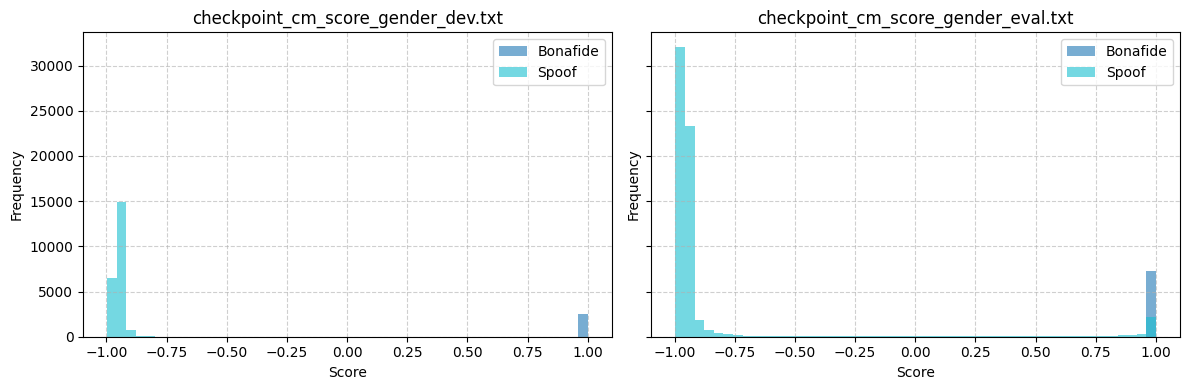

C:\Users\avish\AppData\Local\Temp\ipykernel_28316\2483974319.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_colors = plt.cm.get_cmap("tab10", 2)  # Use 2 colors for bonafide & spoof


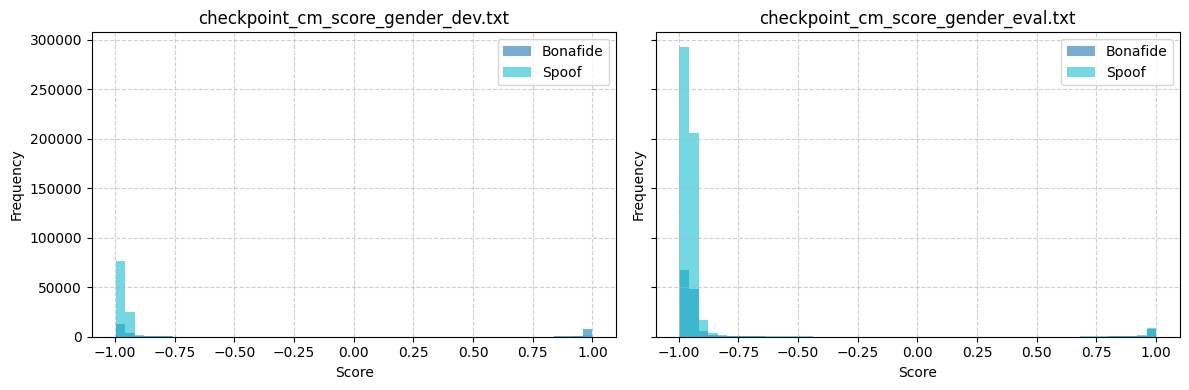

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_histogram_comparison(file_paths, gender="all"):
    num_files = len(file_paths)
    cols = 2  # Number of columns in the subplot grid
    rows = (num_files + cols - 1) // cols  # Calculate required rows
    unique_colors = plt.cm.get_cmap("tab10", 2)  # Use 2 colors for bonafide & spoof

    fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4), sharex=True, sharey=True)
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for idx, file_path in enumerate(file_paths):
        df = pd.read_csv(file_path, delim_whitespace=True, header=None,
                         names=["file_id", "speakers", "attack_type", "label", "score", "gender"])

        mapping_labels = {"bonafide": 1, "spoof": -1}
        df["label"] = df["label"].map(mapping_labels)

        if gender == "male":
            df = df.loc[df["gender"] == "male"]
        elif gender == "female":
            df = df.loc[df["gender"] == "female"]

        # Separate bonafide and spoof scores
        bonafide_scores = df[df["label"] == 1]["score"]
        spoof_scores = df[df["label"] == -1]["score"]

        # Plot histograms
        axes[idx].hist(bonafide_scores, bins=50, alpha=0.6, color=unique_colors(0), label="Bonafide")
        axes[idx].hist(spoof_scores, bins=50, alpha=0.6, color=unique_colors(1), label="Spoof")
        
        # Formatting
        axes[idx].set_title(file_path.split("/")[-1], fontsize=12)
        axes[idx].set_xlabel("Score", fontsize=10)
        axes[idx].set_ylabel("Frequency", fontsize=10)
        axes[idx].legend()
        axes[idx].grid(True, linestyle="--", alpha=0.6)

    # Hide any unused subplots
    for ax in axes[len(file_paths):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

file_paths = [
    "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_dev.txt",
    "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_eval.txt"
]
plot_histogram_comparison(file_paths)

file_paths = [
    "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_dev.txt",
    "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_eval.txt"
]
plot_histogram_comparison(file_paths)

C:\Users\avish\AppData\Local\Temp\ipykernel_28316\2483974319.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_colors = plt.cm.get_cmap("tab10", 2)  # Use 2 colors for bonafide & spoof


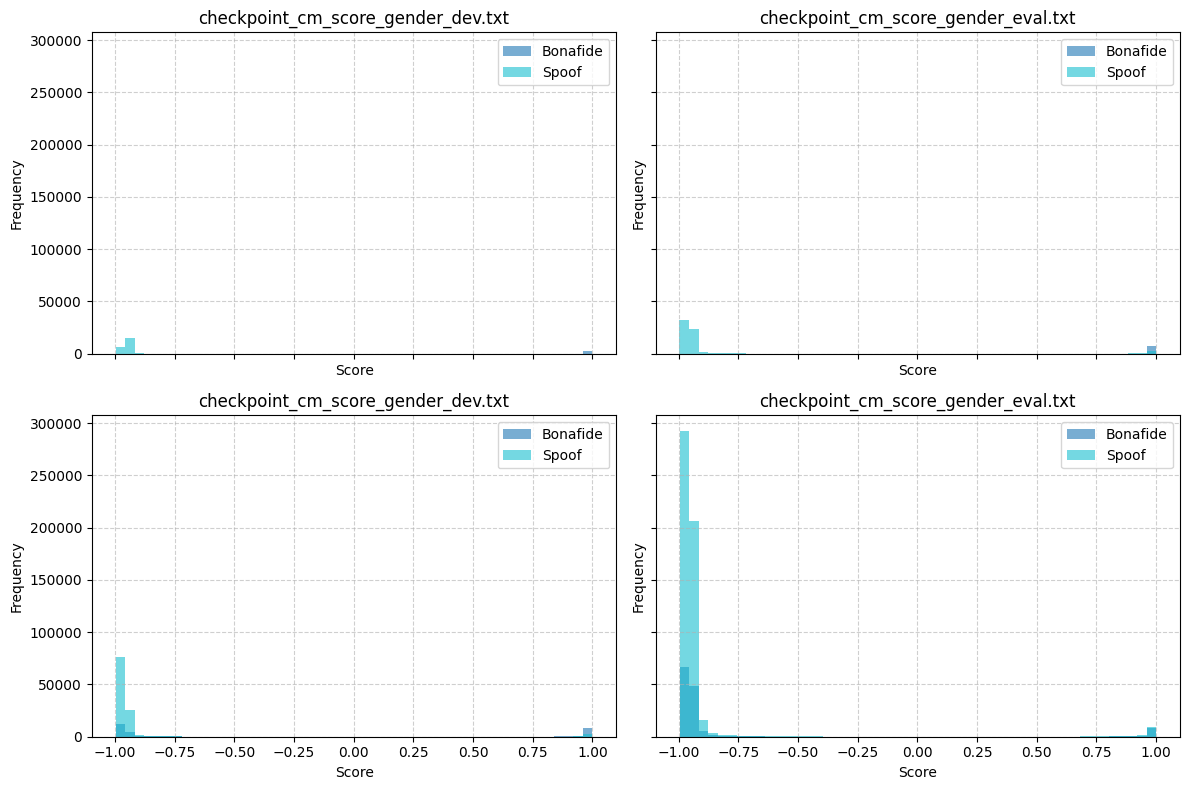

In [9]:
file_paths = [
    "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_dev.txt",
    "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_eval.txt",
    "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_dev.txt",
    "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_eval.txt"
]
plot_histogram_comparison(file_paths)

In [11]:
def compute_eer_from_text_file(file_path, threshold=None,gender = "all"):
    df = pd.read_csv(file_path, delim_whitespace=True, header=None, 
                 names=["file_id", "speakers", "attack_type", "label", "score", "gender"])

    mapping_labels = {"bonafide": 1, "spoof": -1}

    df.label = df.label.map(mapping_labels)
    
    if gender == "male":
        df = df.loc[df["gender"] == "male"]
    
    if gender ==  "female":
        df = df.loc[df["gender"] == "female"]
        

    pred, labels , eer , misclassifications , misclassification_rate = [], [], [], [], []
    if threshold is None:
        
        eer, threshold = compute_eer( y= df.label.values, y_score = df.score.values)
    else:
        pred = (df.score.values > threshold).astype(int)
        labels = df.label.values 
    
    #misscalssification rate
        misclassifications = (pred != labels).sum()  # Count mismatches
        misclassification_rate = misclassifications / len(df)  # Rate
    
    
    return eer, threshold , pred , labels , misclassifications , misclassification_rate


# Define the path to the text file
file_path = "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_dev.txt"

eer_dev, threshold_dev , _ , _ , _ , _ = compute_eer_from_text_file(file_path)
print(f"eer_dev: {eer_dev}, threshold_dev: {threshold_dev}")

eer_dev: 0.002747252747252806, threshold_dev: -0.7637985399174735


In [12]:
file_path = "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_dev_bonafide.txt"

_, _ , pred , labels , misclassifications , misclassification_rate = compute_eer_from_text_file(file_path,threshold_dev)
print(f"eer_dev: {eer_dev}, threshold_dev: {threshold_dev}")

print(f"misclassifications: {misclassifications}")
print(f"misclassification_rate: {100*misclassification_rate}%")

eer_dev: 0.002747252747252806, threshold_dev: -0.7637985399174735
misclassifications: 7
misclassification_rate: 0.27472527472527475%


In [13]:
file_path = "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_eval_bonafide.txt"

_, _ , pred , labels , misclassifications , misclassification_rate = compute_eer_from_text_file(file_path,threshold_dev)
print(f"eer_dev: {eer_dev}, threshold_dev: {threshold_dev}")

print(f"misclassifications: {misclassifications}")
print(f"misclassification_rate: {100*misclassification_rate}%")

eer_dev: 0.002747252747252806, threshold_dev: -0.7637985399174735
misclassifications: 14
misclassification_rate: 0.1903467029231815%


In [14]:
file_path = "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_dev_bonafide.txt"

_, _ , pred , labels , misclassifications , misclassification_rate = compute_eer_from_text_file(file_path,threshold_dev)
print(f"eer_dev: {eer_dev}, threshold_dev: {threshold_dev}")

print(f"misclassifications: {misclassifications}")
print(f"misclassification_rate: {100*misclassification_rate}%")

eer_dev: 0.002747252747252806, threshold_dev: -0.7637985399174735
misclassifications: 18872
misclassification_rate: 60.22850577647284%


In [15]:
file_path = "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_eval_bonafide.txt"

_, _ , pred , labels , misclassifications , misclassification_rate = compute_eer_from_text_file(file_path,threshold_dev)
print(f"eer_dev: {eer_dev}, threshold_dev: {threshold_dev}")

print(f"misclassifications: {misclassifications}")
print(f"misclassification_rate: {100*misclassification_rate}%")

eer_dev: 0.002747252747252806, threshold_dev: -0.7637985399174735
misclassifications: 123954
misclassification_rate: 89.37615366866636%


### Plotting:

C:\Users\avish\AppData\Local\Temp\ipykernel_28316\3420196051.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_colors = plt.cm.get_cmap("tab10", num_files)


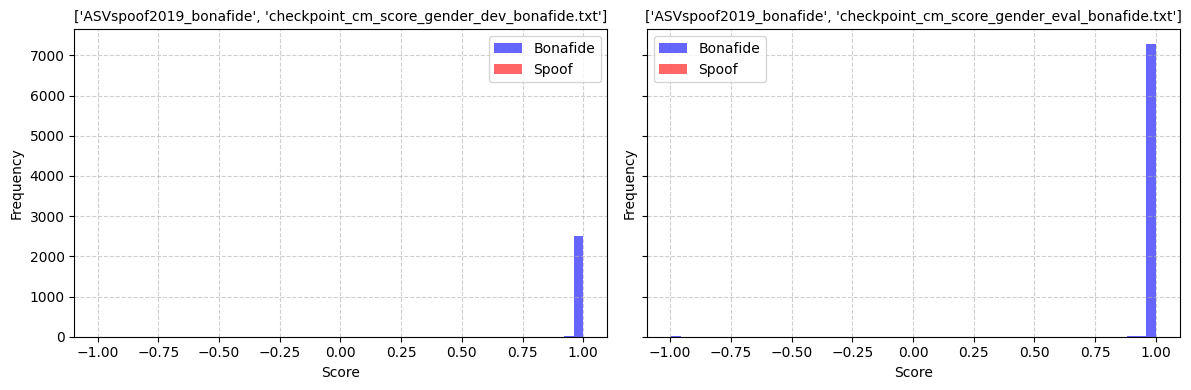

C:\Users\avish\AppData\Local\Temp\ipykernel_28316\3420196051.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_colors = plt.cm.get_cmap("tab10", num_files)


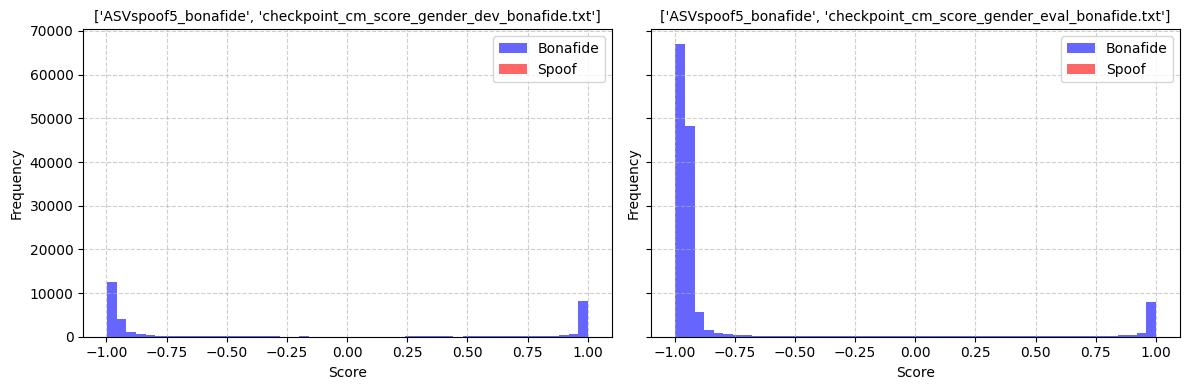

In [27]:

import pandas as pd
import matplotlib.pyplot as plt


import pandas as pd
import matplotlib.pyplot as plt

def plot_histogram_comparison(file_paths, gender="all"):
    num_files = len(file_paths)
    cols = 2  # Number of columns in the subplot grid
    rows = (num_files + cols - 1) // cols  # Calculate required rows
    unique_colors = plt.cm.get_cmap("tab10", num_files)

    fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4), sharex=True, sharey=True)
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for idx, file_path in enumerate(file_paths):
        df = pd.read_csv(file_path, delim_whitespace=True, header=None,
                         names=["file_id", "speakers", "attack_type", "label", "score", "gender"])

        mapping_labels = {"bonafide": 1, "spoof": -1}
        df["label"] = df["label"].map(mapping_labels)

        if gender == "male":
            df = df.loc[df["gender"] == "male"]
        elif gender == "female":
            df = df.loc[df["gender"] == "female"]


        bonafide_scores = df[df["label"] == 1]["score"]
        spoof_scores = df[df["label"] == -1]["score"]
        # Plot histogram in the appropriate subplot
        axes[idx].hist(bonafide_scores, bins=50, alpha=0.6, color="blue", label="Bonafide")
        axes[idx].hist(spoof_scores, bins=50, alpha=0.6, color="red", label="Spoof")
        # axes[idx].hist(df["score"], bins=50, alpha=0.6, color=unique_colors(idx))
        axes[idx].set_title(file_path.split("/")[-2::], fontsize=10)
        axes[idx].set_xlabel("Score", fontsize=10)
        axes[idx].set_ylabel("Frequency", fontsize=10)
        axes[idx].grid(True, linestyle="--", alpha=0.6)
        axes[idx].legend()
        plt.tight_layout()
    # Hide any unused subplots
    for ax in axes[len(file_paths):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()



# Example usage
file_paths = [
    "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_dev_bonafide.txt",
    "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_eval_bonafide.txt"
]
plot_histogram_comparison(file_paths)

file_paths = [
    "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_dev_bonafide.txt",
    "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_eval_bonafide.txt"
    ]
plot_histogram_comparison(file_paths)

C:\Users\avish\AppData\Local\Temp\ipykernel_23128\1075649749.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, vert=True, patch_artist=True, showmeans=True)


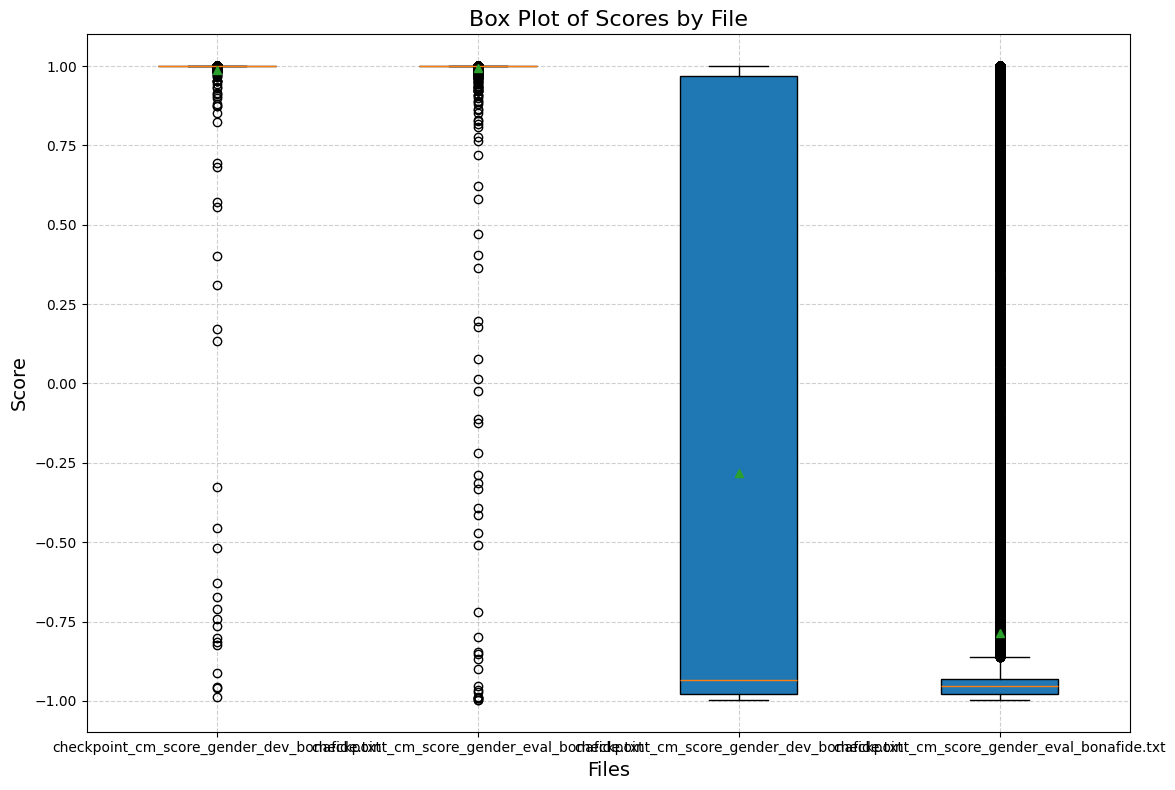

In [8]:
def plot_box_comparison(file_paths, gender="all"):
    data = []
    labels = []

    for file_path in file_paths:
        df = pd.read_csv(file_path, delim_whitespace=True, header=None,
                         names=["file_id", "speakers", "attack_type", "label", "score", "gender"])

        mapping_labels = {"bonafide": 1, "spoof": -1}
        df["label"] = df["label"].map(mapping_labels)

        if gender == "male":
            df = df.loc[df["gender"] == "male"]
        elif gender == "female":
            df = df.loc[df["gender"] == "female"]

        # Collect scores and labels for box plot
        data.append(df["score"])
        labels.append(file_path.split("/")[-1])

    plt.figure(figsize=(12, 8))
    plt.boxplot(data, labels=labels, vert=True, patch_artist=True, showmeans=True)
    plt.title("Box Plot of Scores by File", fontsize=16)
    plt.ylabel("Score", fontsize=14)
    plt.xlabel("Files", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Example usage
plot_box_comparison(file_paths)

# With conf intervals:

In [9]:
import numpy as np
import sklearn.metrics
from utils.my_conf_inter import evaluate_with_conf_int
from utils.my_conf_inter import get_bootstrap_indices, get_conf_int
from confidence_intervals.utils import barplot_with_ci
import warnings
warnings.filterwarnings("ignore")
# Percentage for the confidence interval
alpha = 5 

# Number of bootstrap samples to use (the run time will be proportional to this number). We set it to
# 50/alpha*100 to get enough samples in the tails.
num_bootstraps = int(50/alpha*100)

print(" Number of bootstraps: ", num_bootstraps)
print(" Alpha: ", alpha)

 Number of bootstraps:  1000
 Alpha:  5


In [10]:
def metric1(labels, scores):
    eer, threshold = compute_eer( y= labels, y_score = scores)
    return eer,threshold

def metric2(labels, scores):
    threshold_dev = -0.7637985381451311
    pred = (scores > threshold_dev).astype(int)
    misclassifications = (pred != labels).sum()  # Count mismatches
    misclassification_rate = misclassifications / len(labels)  # Rate   
    
    return misclassifications , 100*misclassification_rate
    

def compute_eer_from_text_file(file_path, threshold=None,gender = "all"):
    df = pd.read_csv(file_path, delim_whitespace=True, header=None, 
                 names=["file_id", "speakers" ,"attack_type", "label", "score", "gender"])

    mapping_labels = {"bonafide": 1, "spoof": -1}

    df.label = df.label.map(mapping_labels)
    
    if gender == "male":
        df = df.loc[df["gender"] == "male"]
    
    if gender ==  "female":
        df = df.loc[df["gender"] == "female"]
    
    speakers = df["speakers"].values.astype(str)
    speakers_int = np.array([int(s[-4:]) for s in speakers])

    pred, labels , eer , res = [], [], [], []
    if threshold is None:
        speakers_int = None
        eer, threshold = evaluate_with_conf_int(samples =  df.score.values, metric = metric1, labels = df.label.values, 
                                              conditions = speakers_int, num_bootstraps=num_bootstraps, alpha=alpha)
    else:
        res = evaluate_with_conf_int(samples =  df.score.values, metric = metric2, labels = df.label.values, 
                                              conditions = speakers_int, num_bootstraps=num_bootstraps, alpha=alpha)
    
    
    return eer, threshold , pred , labels , res


# Define the path to the text file
file_path = "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_dev.txt"

eer_dev_male, threshold_dev_male , _ , _ , _  = compute_eer_from_text_file(file_path,gender = "male")
print(f"Male: eer_dev: {eer_dev_male}, threshold_dev: {threshold_dev_male}")

eer_dev_female, threshold_dev_female , _ , _ , _ = compute_eer_from_text_file(file_path,gender = "female")
print(f"Female: eer_dev: {eer_dev_female}, threshold_dev: {threshold_dev_female}")

eer_dev, threshold_dev , _ , _ , _ = compute_eer_from_text_file(file_path,gender = "all")
print(f"eer_dev: {eer_dev}, threshold_dev: {threshold_dev}")

Male: eer_dev: (0.005411255411116735, array(-0.75675815)), threshold_dev: [(0.003536885662282277, 0.007694810731716051), (-0.8233057260550921, -0.4548098146899915)]
Female: eer_dev: (0.0017857142857142455, array(-0.77178321)), threshold_dev: [(0.0005938154175800659, 0.003036667772817226), (-0.8425731600364033, -0.3266697526370347)]
eer_dev: (0.002747252747252806, array(-0.76379854)), threshold_dev: [(0.001984825713206422, 0.004003483798534033), (-0.8136535883218837, -0.6318034941833556)]


In [11]:
# Define the path to the text file
file_path = "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_dev_bonafide.txt"

_, _ ,pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "male")
print(f"Male misclassifications: {res}")


_, _ , pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "female")
print(f"Female misclassifications: {res}")


_, _ , pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "all")
print(f"misclassifications: {res}")


Male misclassifications: ((4, 0.4608294930875576), [(0.0, 14.024999999999977), (0.0, 1.769706089517831)])
Female misclassifications: ((3, 0.17857142857142858), [(0.0, 11.0), (0.0, 0.6270029582152097)])
misclassifications: ((7, 0.27472527472527475), [(0.0, 21.0), (0.0, 0.8555979174655614)])


In [12]:
# Define the path to the text file
file_path = "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_eval_bonafide.txt"

_, _ ,pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "male")
print(f"Male misclassifications: {res}")


_, _ , pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "female")
print(f"Female misclassifications: {res}")


_, _ , pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "all")
print(f"misclassifications: {res}")

Male misclassifications: ((3, 0.1314060446780552), [(0.0, 10.0), (0.0, 0.4329004329004329)])
Female misclassifications: ((11, 0.2168769716088328), [(2.0, 26.0), (0.03867723844517501, 0.5123410741115414)])
misclassifications: ((14, 0.1903467029231815), [(3.0, 30.0), (0.041796345936625845, 0.391629121607746)])


In [13]:
# Define the path to the text file
file_path = "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_dev_bonafide.txt"

_, _ ,pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "male")
print(f"Male misclassifications: {res}")


_, _ , pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "female")
print(f"Female misclassifications: {res}")


_, _ , pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "all")
print(f"misclassifications: {res}")

Male misclassifications: ((9242, 58.46776744480293), [(8633.775, 9837.0), (55.342859103909866, 61.63969004155981)])
Female misclassifications: ((9630, 62.02099568493592), [(8979.975, 10213.275), (59.24411981223716, 64.89106436418803)])
misclassifications: ((18872, 60.22850577647284), [(18034.825, 19688.3), (58.24040867198589, 62.32598933549198)])


In [14]:
# Define the path to the text file
file_path = "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_eval_bonafide.txt"

_, _ ,pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "male")
print(f"Male misclassifications: {res}")


_, _ , pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "female")
print(f"Female misclassifications: {res}")


_, _ , pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "all")
print(f"misclassifications: {res}")

Male misclassifications: ((60868, 88.92070355869807), [(59951.425, 61746.575), (88.05497687210774, 89.86574547158544)])
Female misclassifications: ((63086, 89.82003530952788), [(62197.675, 63947.025), (88.98757531804543, 90.63048245934829)])
misclassifications: ((123954, 89.37615366866636), [(122672.625, 125187.1), (88.74340151167573, 90.01741836580798)])
